In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
# warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Configure plots
plt.style.use('ggplot')

In [43]:
# #We will be only using ZHVI datasets for timeseries for housing prices
# filePath_ZHVI = {
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_1bedroom_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_2bedroom_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_3bedroom_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_4bedroom_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_5+bedroom_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_All_Homes_Bottom_tier_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_All_Homes_Top_tier_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_Condo-Co-op_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_Single_Family_Homes_time_series.csv",
#     "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_Single_Family_Residence_smoothAdjusted.csv"
# }

# filePath_Sale_Listing = {
#     "updated-zillow-price/For_Sale_Listings/Metro_US_NewlyPendingListings(Smooth,Allhomes,monthly).csv"
# }

# filePath_ZORI = {
#     "updated-zillow-price/Rental(ZORI)/City_ZORI_All_Homes_Plus_Mutlifamily_time_series_(smoothed-seasonallyAdjusted).csv",
#     "updated-zillow-price/Rental(ZORI)/City_ZORI_All_Homes_Plus_Mutlifamily_time_series_(smoothed).csv"
# }

# filePathSalePrice = {
#     "updated-zillow-price/Sales_Price/Metro_US_Mean_Sale_Price_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Mean_Sale_to_List_Ratio_(Smooth,All_Homes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Median_Sale_Price_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Median_Sale_to_List_Ratio_(Smooth,All_Homes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Percent_of_Homes_Sold_Above_List_(Smooth,AllHomes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Percent_of_Homes_Sold_Below_List_(Smooth,AllHomes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Metro_US_Total_Transaction_Value_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv",
#     "updated-zillow-price/Sales_Price/Sales_Count_Nowcast_(Raw,All_Homes).csv"
# }

# fileHeatIndex = "updated-zillow-price/Market_Heat_Index/Metro_US_Market_Heat_Index_(AllHomes,Monthly).csv"

# filePathPriceCut = {
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Mean_Days_to_Close_(Smooth, AllHomes, Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Mean_Days_to_Pending_(Smooth, AllHomes, Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Mean_Price_Cut_(%,Smoothed,AllHomes,Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Mean_Price_Cut_($,Smoothed,AllHomes,Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Median_Days_to_Close_(Smooth, AllHomes, Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Median_Days_to_Pending_(Smooth, AllHomes, Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Median_Price_Cut_(%,Smoothed,AllHomes,Monthly).csv",
#     "updated-zillow-price/Days_On_Market_and_Price_cuts/Metro_US_Median_Price_Cut_($,Smoothed,AllHomes,Monthly).csv"
# }

### Trends we are looking for:
Our goal is to find overall trends and or seasonality in pricing with respect to five main categories. 
1. Top tier and bottom tier housing 
2. The number of bedrooms 
3. Rental proporties
4. Single family homes vs condo
5. Sales and listings 

In [80]:
# Tiers for housing prices
file_paths_tiers = {
    "Bottom_Tier": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_All_Homes_Bottom_tier_time_series.csv",
    "Top_Tier": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_All_Homes_Top_tier_time_series.csv"
}

# Compare how # of bedrooms/estate size affect housing price trends 
file_paths_bedrooms = {
    "1_bedroom": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_1bedroom_time_series.csv",
    "2_bedroom": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_2bedroom_time_series.csv",
    "3_bedroom": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_3bedroom_time_series.csv",
    "4_bedroom": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_4bedroom_time_series.csv",
    "5+_bedroom": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_5+bedroom_time_series.csv"
}

# Rental prices
file_paths_rentals = {
    "multi_fam_rental_seasonal": "updated-zillow-price/Rental(ZORI)/City_ZORI_All_Homes_Plus_Mutlifamily_time_series_(smoothed-seasonallyAdjusted).csv",
    "multi_fam_rental": "updated-zillow-price/Rental(ZORI)/City_ZORI_All_Homes_Plus_Mutlifamily_time_series_(smoothed).csv"
}

# Single family homes vs condos and co-ops
file_paths_single_family = { 
    "single_family": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_Single_Family_Homes_time_series.csv",
    "condo_Co-op": "updated-zillow-price/HomeValues(ZHVI)/City_ZHVI_Condo-Co-op_time_series.csv"
}

# Sales and listing trends
file_paths_sales = {
    "newly_pending_listings": "updated-zillow-price/For_Sale_Listings/Metro_US_NewlyPendingListings(Smooth,Allhomes,monthly).csv",
    "mean_sale_price": "updated-zillow-price/Sales_Price/Metro_US_Mean_Sale_Price_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv",
    "median_sale_price": "updated-zillow-price/Sales_Price/Metro_US_Median_Sale_Price_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv"
    #"sale_to_list_ratio": "updated-zillow-price/Sales_Price/Metro_US_Mean_Sale_to_List_Ratio_(Smooth,All_Homes,Monthly).csv",
    #"median_sale_to_list_ratio": "updated-zillow-price/Sales_Price/Metro_US_Median_Sale_to_List_Ratio_(Smooth,All_Homes,Monthly).csv",
    #"percent_above_list": "updated-zillow-price/Sales_Price/Metro_US_Percent_of_Homes_Sold_Above_List_(Smooth,AllHomes,Monthly).csv",
    #"percent_below_list": "updated-zillow-price/Sales_Price/Metro_US_Percent_of_Homes_Sold_Below_List_(Smooth,AllHomes,Monthly).csv",
    #"total_transaction_value": "updated-zillow-price/Sales_Price/Metro_US_Total_Transaction_Value_(Smooth,SeasonallyAdjusted,All_Homes,Monthly).csv",
    #"sales_count_nowcast": "updated-zillow-price/Sales_Price/Sales_Count_Nowcast_(Raw,All_Homes).csv"
}

In [81]:
# Load the data and preview it for tiers 
bottom_tier_df = pd.read_csv(file_paths_tiers["Bottom_Tier"])
top_tier_df = pd.read_csv(file_paths_tiers["Top_Tier"])

# Load the data and preview it for bedrooms
one_bedroom_df = pd.read_csv(file_paths_bedrooms["1_bedroom"])
two_bedroom_df = pd.read_csv(file_paths_bedrooms["2_bedroom"])
three_bedroom_df = pd.read_csv(file_paths_bedrooms["3_bedroom"])
four_bedroom_df = pd.read_csv(file_paths_bedrooms["4_bedroom"])
five_plus_bedroom_df = pd.read_csv(file_paths_bedrooms["5+_bedroom"])


# Load the data and preview it for rentals 
multi_fam_rental_seasonal_df = pd.read_csv(file_paths_rentals["multi_fam_rental_seasonal"])
multi_fam_rental_df = pd.read_csv(file_paths_rentals["multi_fam_rental"])

# Load the data and preview it for single family homes vs condos and co-ops
single_family_df = pd.read_csv(file_paths_single_family["single_family"])
condo_coop_df = pd.read_csv(file_paths_single_family["condo_Co-op"])

# Load the data and preview it for sales and listings
newly_pending_listings_df = pd.read_csv(file_paths_sales["newly_pending_listings"])
mean_sale_price_df = pd.read_csv(file_paths_sales["mean_sale_price"])
median_sale_price_df = pd.read_csv(file_paths_sales["median_sale_price"])

## Preview data

In [82]:
# Display the first few rows of each dataset
print("Bottom Tier Data:")
display(bottom_tier_df.head())

print("\nTop Tier Data:")
display(top_tier_df.head())

# print("\nOne Bedroom Data:")
# display(one_bedroom_df.head())

# print("\nTwo Bedroom Data:")
# display(two_bedroom_df.head()) 

# print("\nThree Bedroom Data:")
# display(three_bedroom_df.head())

# print("\nFour Bedroom Data:")
# display(four_bedroom_df.head())

# print("\nFive Plus Bedroom Data:")
# display(five_plus_bedroom_df.head())


# print("\nMultifamily Seasonal Rental Data:")
# display(multi_fam_rental_seasonal_df.head())

# print("\Multifamily Non Seasonal Rental Data:")
# display(multi_fam_rental_df.head())

# print("\nsingle Family Data:")
# display(single_family_df.head())

# print("\nCondo Co-op Data:")
# display(condo_coop_df.head())

print("\nNewly Pending Listings Data:")
display(newly_pending_listings_df.head())

print("\nMean Sale Price Data:")
display(mean_sale_price_df.head())

print("\nMedian Sale Price Data:")
display(median_sale_price_df.head())



Bottom Tier Data:


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,135938.093262,136672.233081,...,461923.166998,463171.318404,465953.643715,469142.548055,472480.005497,474590.610662,477165.895357,480334.424266,483028.450059,485195.514445
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,120410.861777,120614.264869,...,668843.532299,664215.199498,659210.586511,657311.420982,657638.408837,657739.438926,660053.626985,664284.651174,670006.775231,674549.647456
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,55418.285342,55415.860445,...,183825.841226,184258.721736,185029.555794,185921.642130,186638.607863,186682.894332,186135.499489,185318.397157,184377.989756,183498.816489
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,71478.725430,71474.655059,...,171815.885212,172423.131077,173586.333992,175624.413260,177272.948519,178365.651537,178847.839398,179256.083273,179427.563834,179387.979344
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,55864.856966,55917.873378,...,169678.755511,169205.285486,169503.587781,170268.484965,170857.340754,170966.394600,170142.893326,169117.236488,167900.851318,166869.334784



Top Tier Data:


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,614413.472712,617772.048290,...,1.335844e+06,1.335482e+06,1.339964e+06,1.345716e+06,1.350540e+06,1.350240e+06,1.350597e+06,1.352696e+06,1.356184e+06,1.358380e+06
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,424997.704968,425616.915266,...,1.686668e+06,1.669100e+06,1.652783e+06,1.645160e+06,1.643073e+06,1.637440e+06,1.637274e+06,1.642561e+06,1.654145e+06,1.662113e+06
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,223689.361591,223655.019919,...,4.589952e+05,4.603469e+05,4.622704e+05,4.643360e+05,4.655674e+05,4.656578e+05,4.650730e+05,4.646022e+05,4.649419e+05,4.654256e+05
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,312838.178372,313070.807642,...,5.047138e+05,5.052110e+05,5.078096e+05,5.108178e+05,5.126829e+05,5.128935e+05,5.126892e+05,5.129747e+05,5.137060e+05,5.143352e+05
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,175956.367623,176153.899258,...,3.913755e+05,3.906418e+05,3.911624e+05,3.920717e+05,3.925350e+05,3.922292e+05,3.913108e+05,3.905081e+05,3.900597e+05,3.899283e+05



Newly Pending Listings Data:


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,192663.0,224120.0,254126.0,259917.0,256762.0,...,178458.0,192350.0,228194.0,256419.0,275354.0,276440.0,270759.0,260710.0,249151.0,239157.0
1,394913,1,"New York, NY",msa,NY,4802.0,5951.0,6933.0,7425.0,7246.0,...,6573.0,6678.0,7878.0,9245.0,10362.0,10542.0,10499.0,9987.0,9347.0,9080.0
2,753899,2,"Los Angeles, CA",msa,CA,7120.0,7876.0,8570.0,8485.0,8471.0,...,3963.0,4221.0,4984.0,5507.0,5941.0,5941.0,5991.0,5825.0,5673.0,5578.0
3,394463,3,"Chicago, IL",msa,IL,9464.0,11438.0,12814.0,12329.0,11518.0,...,4997.0,5524.0,6845.0,8002.0,8644.0,8691.0,8509.0,8023.0,7497.0,7169.0
4,394514,4,"Dallas, TX",msa,TX,6158.0,6986.0,7725.0,8027.0,8047.0,...,4687.0,5237.0,6253.0,7085.0,7472.0,7240.0,6871.0,6508.0,6243.0,5971.0



Mean Sale Price Data:


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,308693.0,307426.0,308973.0,310014.0,309673.0,...,450450.0,451130.0,456146.0,463921.0,471909.0,478433.0,483282.0,484368.0,483049.0,482294.0
1,394913,1,"New York, NY",msa,NY,535453.0,538943.0,541379.0,545620.0,538870.0,...,732951.0,739628.0,743904.0,751571.0,764598.0,782637.0,801839.0,814305.0,820281.0,811442.0
2,753899,2,"Los Angeles, CA",msa,CA,819001.0,814654.0,818758.0,818542.0,814474.0,...,1173309.0,1171431.0,1176898.0,1188951.0,1209256.0,1223671.0,1237356.0,1237069.0,1220697.0,1214699.0
3,394463,3,"Chicago, IL",msa,IL,271408.0,271326.0,272137.0,276174.0,275013.0,...,361073.0,363428.0,365349.0,369158.0,375142.0,381391.0,388957.0,395259.0,396983.0,397154.0
4,394514,4,"Dallas, TX",msa,TX,313499.0,311465.0,309253.0,309457.0,308641.0,...,483313.0,485028.0,487926.0,491672.0,493564.0,498583.0,494432.0,495629.0,489598.0,490678.0



Median Sale Price Data:


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,225774.0,225022.0,225590.0,226883.0,227512.0,...,330965.0,332060.0,336740.0,342697.0,345587.0,347634.0,350245.0,352166.0,353165.0,353274.0
1,394913,1,"New York, NY",msa,NY,388035.0,391200.0,390448.0,392370.0,387555.0,...,571839.0,576482.0,579578.0,581776.0,586441.0,596147.0,606530.0,620962.0,623795.0,623860.0
2,753899,2,"Los Angeles, CA",msa,CA,631472.0,626125.0,624867.0,624481.0,621673.0,...,895896.0,893869.0,899854.0,908896.0,925565.0,935297.0,944458.0,944297.0,935563.0,927461.0
3,394463,3,"Chicago, IL",msa,IL,217299.0,217144.0,217524.0,220729.0,221183.0,...,292853.0,295535.0,297672.0,299949.0,302213.0,304973.0,309702.0,313101.0,313709.0,315823.0
4,394514,4,"Dallas, TX",msa,TX,257706.0,253668.0,251405.0,251783.0,252127.0,...,379868.0,381739.0,382696.0,386710.0,389419.0,391568.0,390212.0,387965.0,386300.0,385942.0


In [83]:
# Function to filter the dataset for Boulder, CO
def filter_boulder_data(df):
    # Filter for Boulder, CO
    boulder_data = df[(df["RegionName"] == "Boulder") & (df["State"] == "CO")]
    
    # If no data found
    if boulder_data.empty:
        print("No data found for Boulder, CO.")
        return None

    # Extract columns that match the time-series format (e.g., 'YYYY-MM-DD' or 'YYYY-MM')
    date_columns = boulder_data.columns[7:]
    valid_date_columns = [col for col in date_columns if col.startswith("20")]
    
    # Create time-series data
    time_series = boulder_data[valid_date_columns].T  # Transpose to get time-series
    time_series.columns = ["Price"]  # Set column name
    time_series.index = pd.to_datetime(valid_date_columns, format='%Y-%m-%d', errors='coerce')  # Explicit format
    return time_series

# Filter data for Boulder, CO in Bottom Tier and Top Tier datasets
boulder_bottom_tier = filter_boulder_data(bottom_tier_df)
boulder_top_tier = filter_boulder_data(top_tier_df)

# Filter data from Boulder, CO in the rental datasets
boulder_fam_rental = filter_boulder_data(multi_fam_rental_seasonal_df)
boulder_multi_rental = filter_boulder_data(multi_fam_rental_df)

# Filter data from Boulder, CO in number of bedrooms datasets
boulder_one_bedroom = filter_boulder_data(one_bedroom_df)
boulder_two_bedroom = filter_boulder_data(two_bedroom_df)
boulder_three_bedroom = filter_boulder_data(three_bedroom_df)
boulder_four_bedroom = filter_boulder_data(four_bedroom_df)
boulder_five_plus_bedroom = filter_boulder_data(five_plus_bedroom_df)

# Filter data from Boulder, CO in single family homes vs condos and co-ops datasets
boulder_single_family = filter_boulder_data(single_family_df)
boulder_condo_coop = filter_boulder_data(condo_coop_df)



# Display the filtered Boulder time-series data
print("Boulder Bottom Tier Time-Series Data:")
print(boulder_bottom_tier.head())

print("\nBoulder Top Tier Time-Series Data:")
print(boulder_top_tier.head())


print("\nBoulder Multi-Family Rental Seasonal Time-Series Data:")
print(boulder_fam_rental.head())

print("\n Boulder One bedroom Time-Series Data")
print(boulder_one_bedroom.head())

print("\n Boulder Two bedroom Time-Series Data")
print(boulder_two_bedroom.head())

print("\n Boulder Three bedroom Time-Series Data")
print(boulder_three_bedroom.head())

print("\n Boulder Four bedroom Time-Series Data")
print(boulder_four_bedroom.head())

print("\n Boulder Five Plus bedroom Time-Series Data")
print(boulder_five_plus_bedroom.head())

print("\n Boulder Single Family Time-Series Data")
print(boulder_single_family.head())

print("\n Boulder Condo Co-op Time-Series Data")
print(boulder_condo_coop.head())


Boulder Bottom Tier Time-Series Data:
                    Price
2000-01-31  149254.622015
2000-02-29  149902.154903
2000-03-31  150707.974410
2000-04-30  152410.359014
2000-05-31  154331.340536

Boulder Top Tier Time-Series Data:
                    Price
2000-01-31  488939.691554
2000-02-29  490760.819223
2000-03-31  493239.606539
2000-04-30  498567.510918
2000-05-31  504742.094134

Boulder Multi-Family Rental Seasonal Time-Series Data:
                  Price
2015-01-31  1721.281905
2015-02-28  1751.133148
2015-03-31  1760.301924
2015-04-30  1775.189121
2015-05-31  1782.967814

 Boulder One bedroom Time-Series Data
                    Price
2000-01-31  112856.727408
2000-02-29  113353.656104
2000-03-31  113878.234398
2000-04-30  115045.413328
2000-05-31  116245.902840

 Boulder Two bedroom Time-Series Data
                    Price
2000-01-31  170365.233061
2000-02-29  171136.720150
2000-03-31  172026.295746
2000-04-30  173971.202134
2000-05-31  176082.408742

 Boulder Three bedroom 

In [84]:
def filter_boulder_sales_listings(df):
    # Filter for Boulder, CO 
    boulder_data_sales_listings = df[(df["RegionID"] == 394405) & (df["StateName"] == "CO")]
    
    # If no data found
    if boulder_data_sales_listings.empty:
        print("No data found for Boulder, CO.")
        return None
    
    
    # Extract columns that match the time-series format (e.g., 'YYYY-MM-DD' or 'YYYY-MM')
    date_columns = boulder_data_sales_listings.columns[4:]
    valid_date_columns = [col for col in date_columns if col.startswith("20")]
    
    time_series = boulder_data_sales_listings[valid_date_columns].T  # Transpose to get time-series
    time_series.columns = ["Price"]  # Set column name
    time_series.index = pd.to_datetime(valid_date_columns, format='%Y-%m-%d', errors='coerce')  # Explicit format
    return time_series 

# Filter data from Boulder, CO in sales and listings datasets
boulder_newly_pending_listings = filter_boulder_sales_listings(newly_pending_listings_df)
boulder_mean_sale_price = filter_boulder_sales_listings(mean_sale_price_df)
boulder_median_sale_price = filter_boulder_sales_listings(median_sale_price_df)

("\nBoulder Newly Pending Listings Time-Series Data:")
print(boulder_newly_pending_listings.head())

print("\nBoulder Mean Sale Price Time-Series Data:")
print(boulder_mean_sale_price.head())

print("\nBoulder Median Sale Price Time-Series Data:")
print(boulder_median_sale_price.head())

            Price
2018-03-31  186.0
2018-04-30  218.0
2018-05-31  261.0
2018-06-30  271.0
2018-07-31  264.0

Boulder Mean Sale Price Time-Series Data:
               Price
2018-08-31  629316.0
2018-09-30  621073.0
2018-10-31  623760.0
2018-11-30  615258.0
2018-12-31  633184.0

Boulder Median Sale Price Time-Series Data:
               Price
2018-08-31  494627.0
2018-09-30  492851.0
2018-10-31  495563.0
2018-11-30  497301.0
2018-12-31  511051.0


### Plot of bottom tier and top tier trends

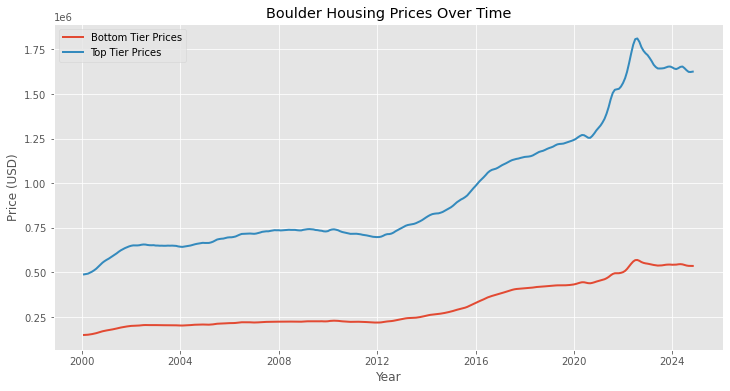

In [85]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(boulder_bottom_tier.index, boulder_bottom_tier["Price"], label="Bottom Tier Prices", linewidth=2)
plt.plot(boulder_top_tier.index, boulder_top_tier["Price"], label="Top Tier Prices", linewidth=2)
plt.title("Boulder Housing Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of pricing trends over time with 1 bedroom, 2 bedroom, 3 bedroom, 4 bedroom, and 5 plus bedroom 

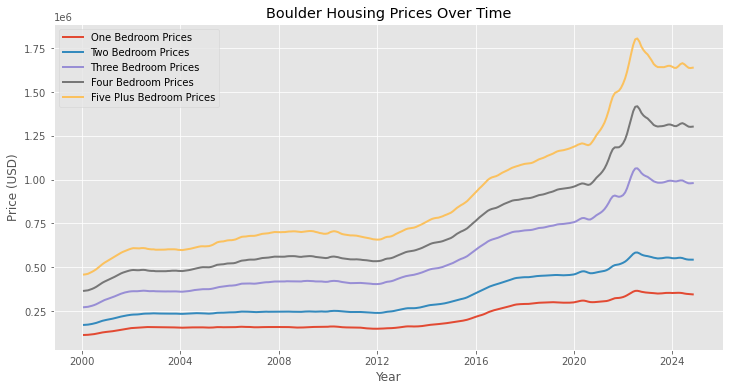

In [86]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(boulder_one_bedroom.index, boulder_one_bedroom["Price"], label="One Bedroom Prices", linewidth=2)
plt.plot(boulder_two_bedroom.index, boulder_two_bedroom["Price"], label="Two Bedroom Prices", linewidth=2)
plt.plot(boulder_three_bedroom.index, boulder_three_bedroom["Price"], label="Three Bedroom Prices", linewidth=2)
plt.plot(boulder_four_bedroom.index, boulder_four_bedroom["Price"], label="Four Bedroom Prices", linewidth=2)
plt.plot(boulder_five_plus_bedroom.index, boulder_five_plus_bedroom["Price"], label="Five Plus Bedroom Prices", linewidth=2)
plt.title("Boulder Housing Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of pricing trends with rentals

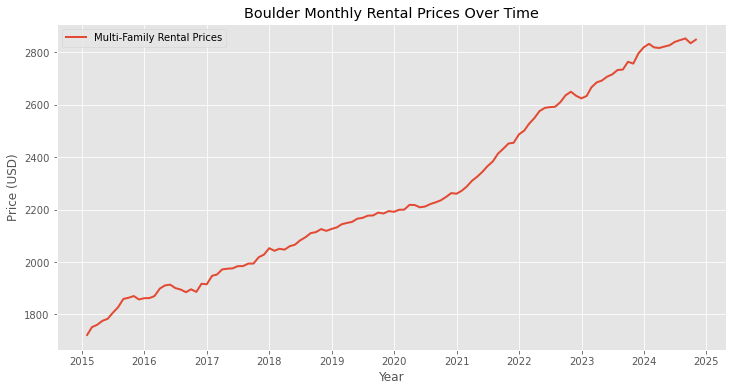

In [87]:
plt.figure(figsize=(12,6))
plt.plot(boulder_fam_rental.index, boulder_fam_rental["Price"], label="Multi-Family Rental Prices", linewidth=2)
plt.title("Boulder Monthly Rental Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of single family homes vs Condos

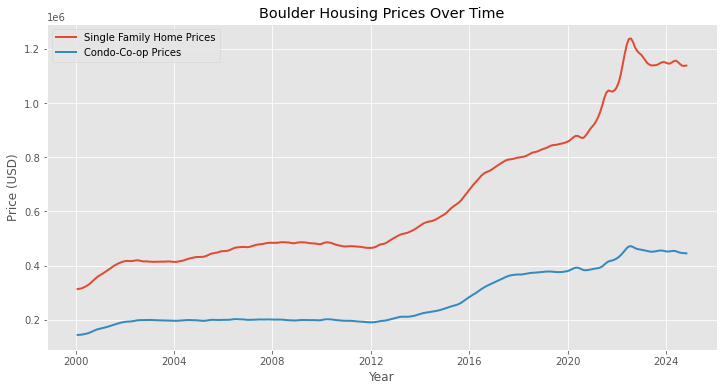

In [88]:
plt.figure(figsize=(12,6))
plt.plot(boulder_single_family.index, boulder_single_family["Price"], label="Single Family Home Prices", linewidth=2)
plt.plot(boulder_condo_coop.index, boulder_condo_coop["Price"], label="Condo-Co-op Prices", linewidth=2)
plt.title("Boulder Housing Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of trend on initial listings. 
### Keep for now and figure out if data is scaled 
### IF not this shit is trash. Ain't nobody listing a house at 300$

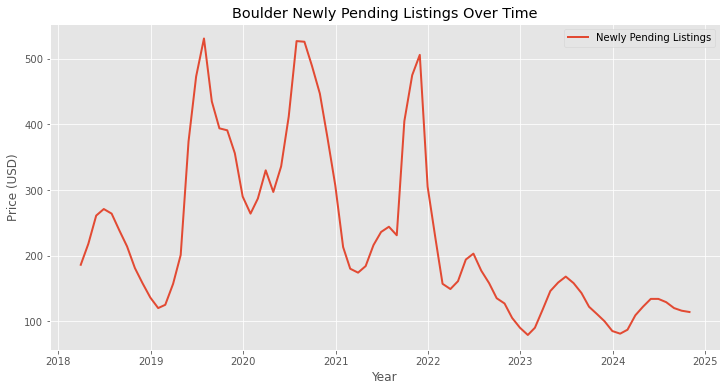

In [89]:
plt.figure(figsize=(12,6))
plt.plot(boulder_newly_pending_listings.index, boulder_newly_pending_listings["Price"], label="Newly Pending Listings", linewidth=2)
plt.title("Boulder Newly Pending Listings Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of mean sales over time

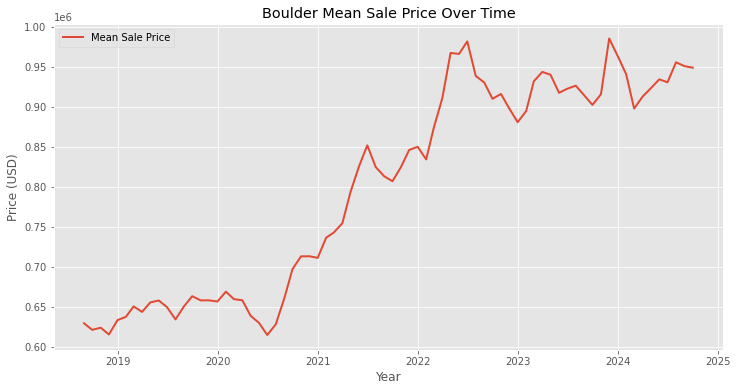

In [90]:
plt.figure(figsize=(12,6))
plt.plot(boulder_mean_sale_price.index, boulder_mean_sale_price["Price"], label="Mean Sale Price", linewidth=2)
plt.title("Boulder Mean Sale Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Plot of median sales over time

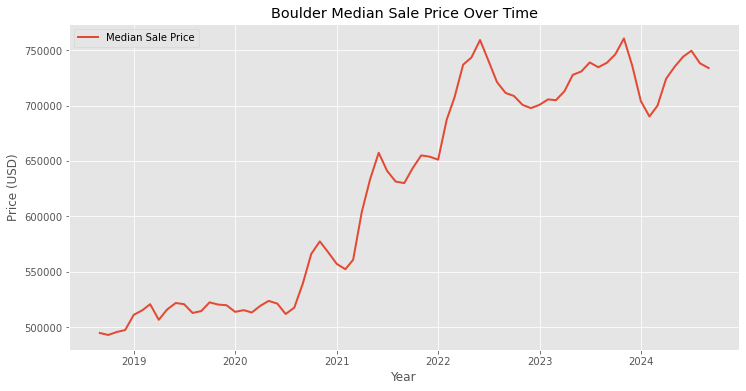

In [91]:
plt.figure(figsize=(12,6))
plt.plot(boulder_median_sale_price.index, boulder_median_sale_price["Price"], label="Median Sale Price", linewidth=2)
plt.title("Boulder Median Sale Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Use ADF test to ensure everything is compatible for ARIMA and SARIMA models

In [92]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
#Use this to check if time-series is stationary... Its essentail for ARIMA/SARIMA because models assume that statistical properties (mean, variance, autocorrelation) of time series don't change over time
def check_stationarity(time_series):
    result = adfuller(time_series["Price"])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05: # 95 % confidence interval
        print("The data is stationary.\n")
    else:
        print("The data is not stationary.\n")

# Check stationarity for Bottom Tier and Top Tier
print("Bottom Tier Stationarity Check:")
check_stationarity(boulder_bottom_tier)
print("\nTop Tier Stationarity Check:")
check_stationarity(boulder_top_tier)

# Check stationarity for Bedrooms
print("\nOne Bedroom Stationarity Check:")
check_stationarity(boulder_one_bedroom)
print("\nTwo Bedroom Stationarity Check:") 
check_stationarity(boulder_two_bedroom)
print("\nThree Bedroom Stationarity Check:")
check_stationarity(boulder_three_bedroom)
print("\nFour Bedroom Stationarity Check:")
check_stationarity(boulder_four_bedroom)
print("\nFive Plus Bedroom Stationarity Check:")
check_stationarity(boulder_five_plus_bedroom)

#Check stationarity for rentals
print("\nMulti-Family Rental Seasonal Stationarity Check:")
check_stationarity(boulder_fam_rental)

#Check stationarity for single family homes vs condos and co-ops
print("\nSingle Family Stationarity Check:")
check_stationarity(boulder_single_family)
print()
print("\nCondo Co-op Stationarity Check:")
check_stationarity(boulder_condo_coop)

#Check stationarity for sales and listings
print("\nNewly Pending Listings Stationarity Check:")
check_stationarity(boulder_newly_pending_listings)
print("\nMean Sale Price Stationarity Check:")
check_stationarity(boulder_mean_sale_price)
print("\nMedian Sale Price Stationarity Check:")
check_stationarity(boulder_median_sale_price)



Bottom Tier Stationarity Check:
ADF Statistic: 0.0698003901725021
p-value: 0.9639377059261913
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796
The data is not stationary.


Top Tier Stationarity Check:
ADF Statistic: 0.22854307686521513
p-value: 0.9738178100867033
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796
The data is not stationary.


One Bedroom Stationarity Check:
ADF Statistic: -0.4089309083928702
p-value: 0.9085969224442714
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796
The data is not stationary.


Two Bedroom Stationarity Check:
ADF Statistic: -0.03259846445225581
p-value: 0.9557517449713578
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796
The data is not stationary.


Three Bedroom Stationarity Check:
ADF Statistic: 0.24027543331157306
p-value: 0.9744321786031914
Critical Value

In [93]:
# Since not stationary, since p-values were greater than 0.10, ADF were not less than critical values
# To make data stationary, we need to apply transformations to remove the trend and stabilize variance.
# WE did differening: Subtract each data point from previous point to remove trends
# This made the series fluctuate around constant mean

# Apply first-order differencing to top and bottom tier data
boulder_bottom_tier_diff = boulder_bottom_tier.diff().dropna()
boulder_top_tier_diff = boulder_top_tier.diff().dropna()

# Apply first-order differencing to bedrooms data
boulder_one_bedroom_diff = boulder_one_bedroom.diff().dropna()
boulder_two_bedroom_diff = boulder_two_bedroom.diff().dropna()
boulder_three_bedroom_diff = boulder_three_bedroom.diff().dropna()
boulder_four_bedroom_diff = boulder_four_bedroom.diff().dropna()
boulder_five_plus_bedroom_diff = boulder_five_plus_bedroom.diff().dropna()

# Apply first-order differencing to rentals data
boulder_fam_rental_diff = boulder_fam_rental.diff().dropna()

# Apply first-order differencing to single family homes vs condos and co-ops data
boulder_single_family_diff = boulder_single_family.diff().dropna()
boulder_condo_coop_diff = boulder_condo_coop.diff().dropna()

# Apply first-order differencing to sales and listings data
boulder_newly_pending_listings_diff = boulder_newly_pending_listings.diff().dropna()
boulder_mean_sale_price_diff = boulder_mean_sale_price.diff().dropna()
boulder_median_sale_price_diff = boulder_median_sale_price.diff().dropna()

#Re-run the ADF test
print("Bottom Tier Stationarity Check After Differencing:")
check_stationarity(boulder_bottom_tier_diff)

print("\nTop Tier Stationarity Check After Differencing:")
check_stationarity(boulder_top_tier_diff)

print("One Bedroom Stationarity Check After Differencing:")
check_stationarity(boulder_one_bedroom_diff)

print("\nTwo Bedroom Stationarity Check After Differencing:")
check_stationarity(boulder_two_bedroom_diff)

print("\nThree Bedroom Stationarity Check After Differencing:")
check_stationarity(boulder_three_bedroom_diff)

print("\nFour Bedroom Stationarity Check After Differencing:")
check_stationarity(boulder_four_bedroom_diff)

print("\nFive Plus Bedroom Stationarity Check After Differencing:")
check_stationarity(boulder_five_plus_bedroom_diff)

print("\nMulti-Family Rental Seasonal Stationarity Check After Differencing:")
check_stationarity(boulder_fam_rental_diff)

print("\nSingle Family Stationarity Check After Differencing:")
check_stationarity(boulder_single_family_diff)

print("\nCondo Co-op Stationarity Check After Differencing:")
check_stationarity(boulder_condo_coop_diff)

print("\nNewly Pending Listings Stationarity Check After Differencing:")
check_stationarity(boulder_newly_pending_listings_diff)

print("\nMean Sale Price Stationarity Check After Differencing:")
check_stationarity(boulder_mean_sale_price_diff)

print("\nMedian Sale Price Stationarity Check After Differencing:")
check_stationarity(boulder_median_sale_price_diff)

Bottom Tier Stationarity Check After Differencing:
ADF Statistic: -3.3114111466144416
p-value: 0.014376037837642592
Critical Values:
   1%: -3.453922368485787
   5%: -2.871918329081633
   10%: -2.5723001147959184
The data is stationary.


Top Tier Stationarity Check After Differencing:
ADF Statistic: -4.025970925868224
p-value: 0.0012804617425108138
Critical Values:
   1%: -3.453922368485787
   5%: -2.871918329081633
   10%: -2.5723001147959184
The data is stationary.

One Bedroom Stationarity Check After Differencing:
ADF Statistic: -2.7863906245643744
p-value: 0.06024422082024574
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796
The data is not stationary.


Two Bedroom Stationarity Check After Differencing:
ADF Statistic: -3.385271332481546
p-value: 0.011471336199443143
Critical Values:
   1%: -3.453922368485787
   5%: -2.871918329081633
   10%: -2.5723001147959184
The data is stationary.


Three Bedroom Stationarity Check After Differ

Since all categories are stationary, meaning they have a consistent mean and varience throughout time, we can use ARIMA and SARIMA.

# Using Arima and SARIMA Models:
We will use ARIMA to forecast and predict long term future trends while SARIMA will be used if seasonality is suspected (Housing prices, rental prices etc...)
Steps:
We will plot the ACT (Autocorrelation Function) and PACF (Partial Autocorrelation Function) for both differenced datasets to estimate the ARIMA parameters:
p: Number of lag terms (From PACF)
q: Number of moving average terms (FROM ACF)

Then we will forcast: Use fitted models to forecast future housing prices and compare trends between bottom tier and top tier

## Plot ACF and PACF for tiers

ACF and PACF for Bottom Tier:


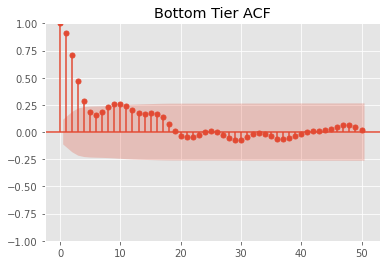

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


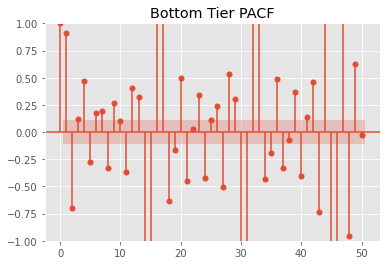

ACF and PACF for Top Tier:


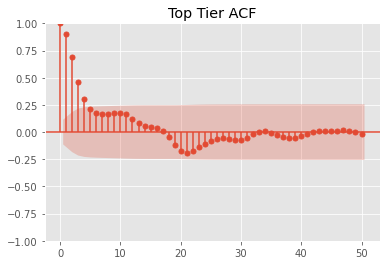

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


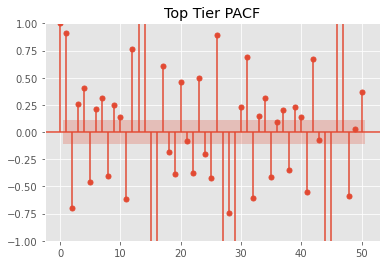

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#Plot ACF and PACF for Bottom Tier
print("ACF and PACF for Bottom Tier:")
plot_acf(boulder_bottom_tier_diff, lags=50)
plt.title("Bottom Tier ACF")
plt.show()

plot_pacf(boulder_bottom_tier_diff, lags=50)
plt.title("Bottom Tier PACF")
plt.show()

# Plot ACF and PACF for Top Tier
print("ACF and PACF for Top Tier:")
plot_acf(boulder_top_tier_diff, lags=50)
plt.title("Top Tier ACF")
plt.show()

plot_pacf(boulder_top_tier_diff, lags=50)
plt.title("Top Tier PACF")
plt.show()




## Plot ACF and PACF for bedrooms

ACF and PACF for One Bedroom:


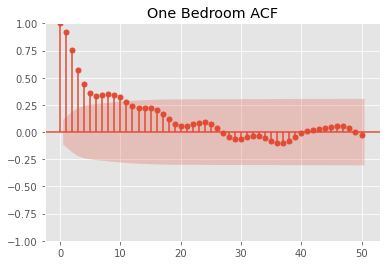

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


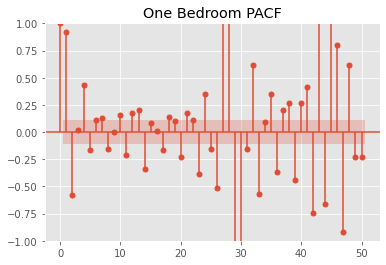

ACF and PACF for Two Bedroom:


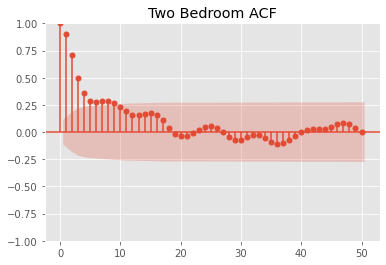

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


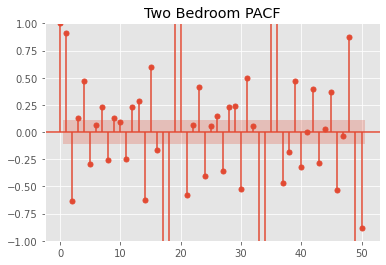

ACF and PACF for Three Bedroom:


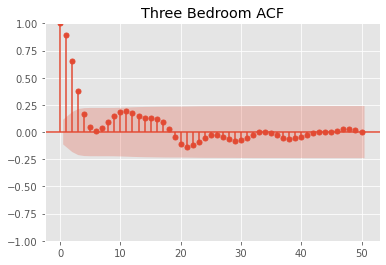

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


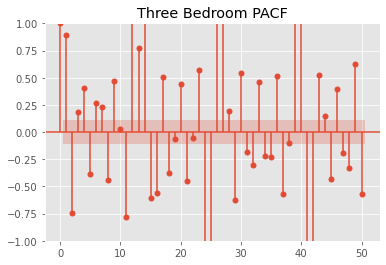

ACF and PACF for Four Bedroom:


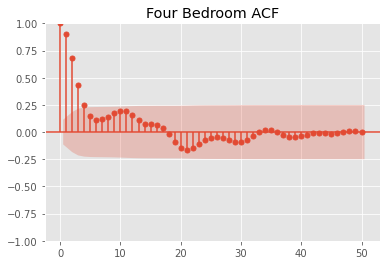

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


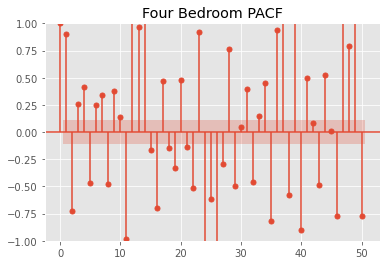

ACF and PACF for Five Plus Bedroom:


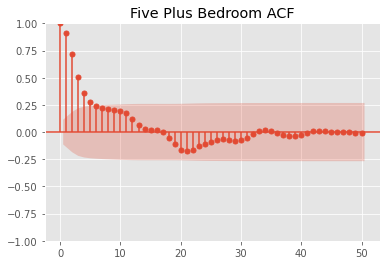

In [94]:
# Plot ACF and PACF for bedrooms
print("ACF and PACF for One Bedroom:")
plot_acf(boulder_one_bedroom_diff, lags=50)
plt.title("One Bedroom ACF")
plt.show()

plot_pacf(boulder_one_bedroom_diff, lags=50)
plt.title("One Bedroom PACF")
plt.show()

print("ACF and PACF for Two Bedroom:")
plot_acf(boulder_two_bedroom_diff, lags=50)
plt.title("Two Bedroom ACF")
plt.show()

plot_pacf(boulder_two_bedroom_diff, lags=50)
plt.title("Two Bedroom PACF")
plt.show()

print("ACF and PACF for Three Bedroom:")
plot_acf(boulder_three_bedroom_diff, lags=50)
plt.title("Three Bedroom ACF")
plt.show()

plot_pacf(boulder_three_bedroom_diff, lags=50)
plt.title("Three Bedroom PACF")
plt.show()

print("ACF and PACF for Four Bedroom:")
plot_acf(boulder_four_bedroom_diff, lags=50)
plt.title("Four Bedroom ACF")
plt.show()

plot_pacf(boulder_four_bedroom_diff, lags=50)
plt.title("Four Bedroom PACF")
plt.show()

print("ACF and PACF for Five Plus Bedroom:")
plot_acf(boulder_five_plus_bedroom_diff, lags=50)
plt.title("Five Plus Bedroom ACF")
plt.show()

## Plot ACF and PACF for rentals

ACF and PACF for Multi-Family Rental Seasonal:


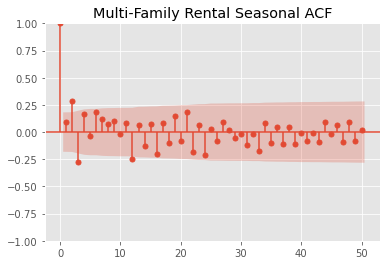

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


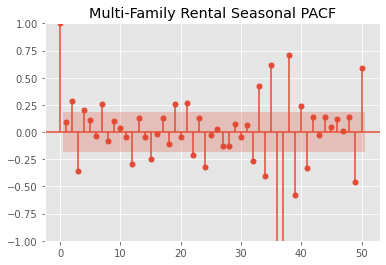

In [95]:
# Plot ACF and PACF for rentals
print("ACF and PACF for Multi-Family Rental Seasonal:")
plot_acf(boulder_fam_rental_diff, lags=50)
plt.title("Multi-Family Rental Seasonal ACF")
plt.show()

plot_pacf(boulder_fam_rental_diff, lags=50)
plt.title("Multi-Family Rental Seasonal PACF")
plt.show()


## Plot ACF and PACF for single family and condo

ACF and PACF for Single Family:


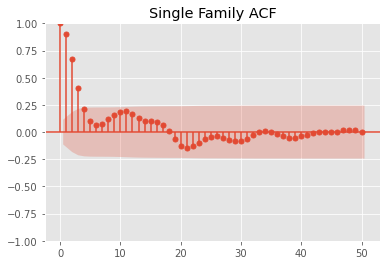

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


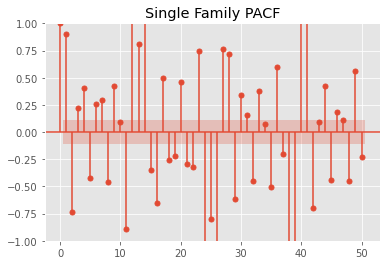

ACF and PACF for Condo Co-op:


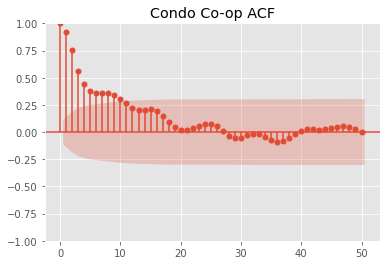

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


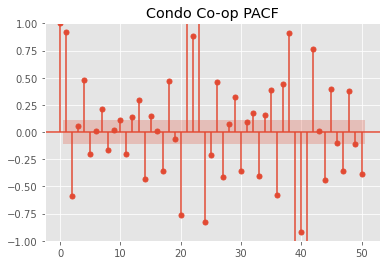

In [96]:
# Plot ACF and PACF for single family homes vs condos and co-ops
print("ACF and PACF for Single Family:")
plot_acf(boulder_single_family_diff, lags=50)
plt.title("Single Family ACF")
plt.show()

plot_pacf(boulder_single_family_diff, lags=50)
plt.title("Single Family PACF")
plt.show()

print("ACF and PACF for Condo Co-op:")
plot_acf(boulder_condo_coop_diff, lags=50)
plt.title("Condo Co-op ACF")
plt.show()

plot_pacf(boulder_condo_coop_diff, lags=50)
plt.title("Condo Co-op PACF")
plt.show()

## Plot ACF and PACF for sales and listings

ACF and PACF for Newly Pending Listings:


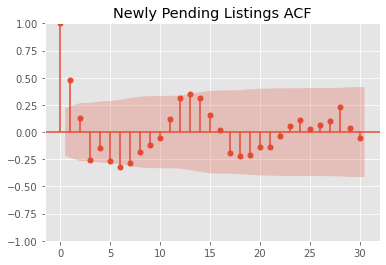

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


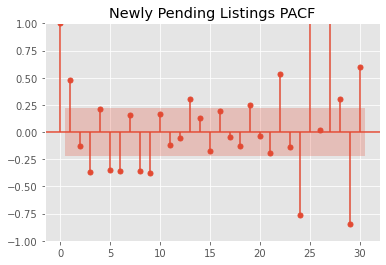

ACF and PACF for Mean Sale Price:


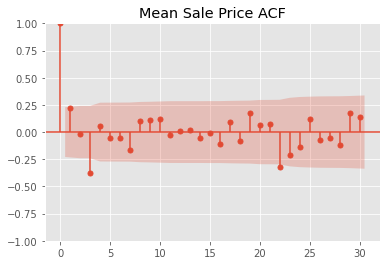

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


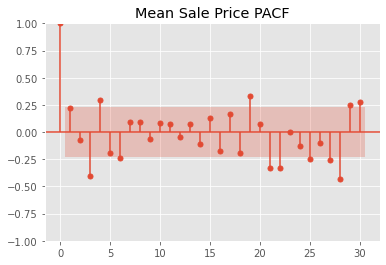

ACF and PACF for Median Sale Price:


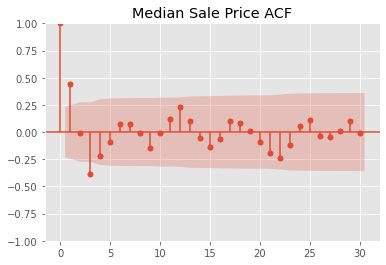

In [97]:
# Plot ACF and PACF for sales and listings
print("ACF and PACF for Newly Pending Listings:")
plot_acf(boulder_newly_pending_listings_diff, lags=30)
plt.title("Newly Pending Listings ACF")
plt.show()

plot_pacf(boulder_newly_pending_listings_diff, lags=30)
plt.title("Newly Pending Listings PACF")
plt.show()

print("ACF and PACF for Mean Sale Price:")
plot_acf(boulder_mean_sale_price_diff, lags=30)
plt.title("Mean Sale Price ACF")
plt.show()

plot_pacf(boulder_mean_sale_price_diff, lags=30)
plt.title("Mean Sale Price PACF")
plt.show()

print("ACF and PACF for Median Sale Price:")
plot_acf(boulder_median_sale_price_diff, lags=30)
plt.title("Median Sale Price ACF")
plt.show()

1. ACF (Autocorrelation Function)
The ACF plot shows the correlation between the time series and its lagged values. In simpler terms, it tells you how much today's data is related to data from previous days, months, or years.
Each bar in the ACF plot represents the correlation (or strength of the relationship) between the series and its lags:
Lag 1 means "today vs yesterday."
Lag 2 means "today vs two days ago," and so on.
Key Observations:
Slow decay in the ACF: Suggests that the data may be non-stationary (but you've already differenced the data to make it stationary).
Significant spikes at specific lags: This can indicate how many terms you might need in the Moving Average (MA) part of the ARIMA model (q parameter).
In your plot:

* For Bottom Tier, the ACF shows a gradual decay but has some clear spikes near the first few lags. This suggests there may be some short-term dependencies in the series.

* For Top Tier, the behavior is similar, with significant correlations at early lags.

* For Single Family Homes, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies. It looks very similar to bottom tier and top tier.

* For condos, we see a similar spike in early lags that are present in single family, but with less of an overall decay throughout the whole thing. 

* For Newly Pending Listings, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies.

* For mean sale price, the ACF shows shows a sharp decay with significant spikes at the first lag, indicating short term dependencies

* For median sale price, we have the same story as with the mean. 


* For One Bedroom, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies.

* For Two Bedroom, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies. It also has a less steep decline after the first few lags. 

* For Three Bedroom, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies. It features a steeper cut off after the first few lags. 

* For Four Bedroom, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies. Is has a very similar shape to the rest 

* For Five Plus Bedroom, the ACF shows a gradual decay with significant spikes at early lags, indicating short-term dependencies. It has a very similar shape to the rest. 



2. PACF (Partial Autocorrelation Function)
The PACF plot shows the correlation between the time series and its lagged values after removing the effects of intermediate lags. This isolates the "direct" relationship between a time point and its lag.
It helps determine the number of AutoRegressive (AR) terms (p parameter) in the ARIMA model.
Key Observations:
Cut-off in PACF: A sharp drop-off after a certain lag suggests the number of AR terms to include (p).
For example:
If the PACF cuts off after lag 2, you might choose p = 2.
In your plot:

For Bottom Tier, the PACF cuts off sharply after lag 1 or 2, suggesting an AR(1) or AR(2) might work well.

For Top Tier, it cuts off similarly, suggesting similar AR terms.


# TODO look a PACF values to determine # of parameters for the rest of the categories. 

In [98]:
# Recalculate the differenced datasets
bottom_tier_diff = boulder_bottom_tier["Price"].diff().dropna()
top_tier_diff = boulder_top_tier["Price"].diff().dropna()

# Define ARIMA parameters based on earlier observations
bottom_tier_params = (2, 1, 1)  # p=2, d=1, q=1
top_tier_params = (2, 1, 1)

# Fit ARIMA models for Bottom Tier and Top Tier
bottom_tier_arima = ARIMA(bottom_tier_diff, order=bottom_tier_params).fit()
top_tier_arima = ARIMA(top_tier_diff, order=top_tier_params).fit()

# Print summaries of the fitted ARIMA models
print("Bottom Tier ARIMA Model Summary:")
print(bottom_tier_arima.summary())
print("\nTop Tier ARIMA Model Summary:")
print(top_tier_arima.summary())

# Do same thing for rest of the categories 

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.p

Bottom Tier ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  297
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2370.839
Date:                Sun, 08 Dec 2024   AIC                           4749.678
Time:                        00:20:10   BIC                           4764.440
Sample:                    02-29-2000   HQIC                          4755.588
                         - 10-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4198      0.026     55.440      0.000       1.370       1.470
ar.L2         -0.7071      0.020    -35.905      0.000      -0.746      -0.668
ma.L1         -0.80

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.p

1. Bottom Tier ARIMA model:
* p = 2: Two autoregressive terms:
* d = 1: First differeing applied to make data stationary
* q = 1: One moving average term
Coefficients: Signficiant ar.L1 and ar.L2 (Autoregressive terms) and ma.L1 (moving average term), with p-values close to 0.

Sigma^2 Variance of residiuals are 5.285e+05 which seem reasonable for housing price differences.

Diagnostics: Ljung-Box Test (Q): No significant autocorrelation in residuals at lag 1. Jarque-Bera Test (JB): Residuals are not normally distributed (Kurtosis > 5).

2. Top Tier ARIMA model:
* p = 2: Two autoregressive terms:
* d = 1: First differeing applied to make data stationary
* q = 1: One moving average term Coefficients: The AR and MA terms are highly significant with p-values near 0.
Sigma^2: Variance of residuals is 7.094e+06, which is higher than the bottom tier (reflecting the higher price range of top-tier homes).

Diagnostics: Ljung-Box Test (Q): No significant autocorrelation in residuals. Jarque-Bera Test (JB): Residuals deviate significantly from normality (Kurtosis > 7).

In [99]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Refit the ARIMA models for both Bottom Tier and Top Tier
bottom_tier_model = ARIMA(bottom_tier_diff, order=(2, 1, 1)).fit()
top_tier_model = ARIMA(top_tier_diff, order=(2, 1, 1)).fit()

# Display model summaries
print("Bottom Tier ARIMA Model Summary:")
print(bottom_tier_model.summary())

print("\nTop Tier ARIMA Model Summary:")
print(top_tier_model.summary())

# TODO Refit the ARIMA models for the rest of the categories

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.p

Bottom Tier ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  297
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2370.839
Date:                Sun, 08 Dec 2024   AIC                           4749.678
Time:                        00:20:21   BIC                           4764.440
Sample:                    02-29-2000   HQIC                          4755.588
                         - 10-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4198      0.026     55.440      0.000       1.370       1.470
ar.L2         -0.7071      0.020    -35.905      0.000      -0.746      -0.668
ma.L1         -0.80

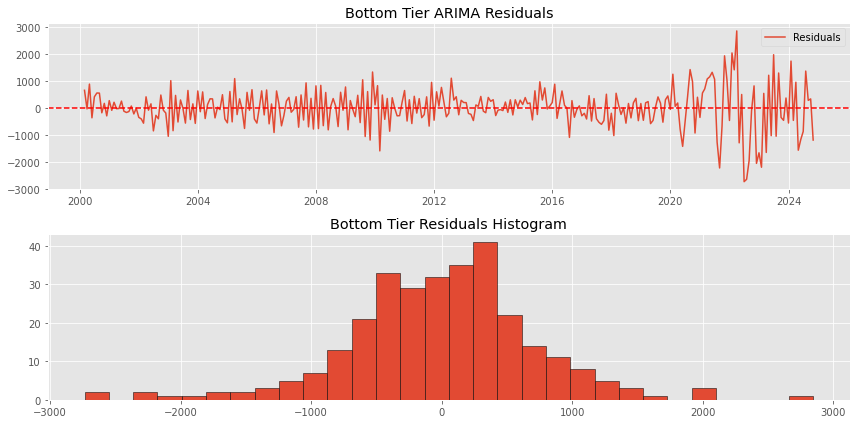

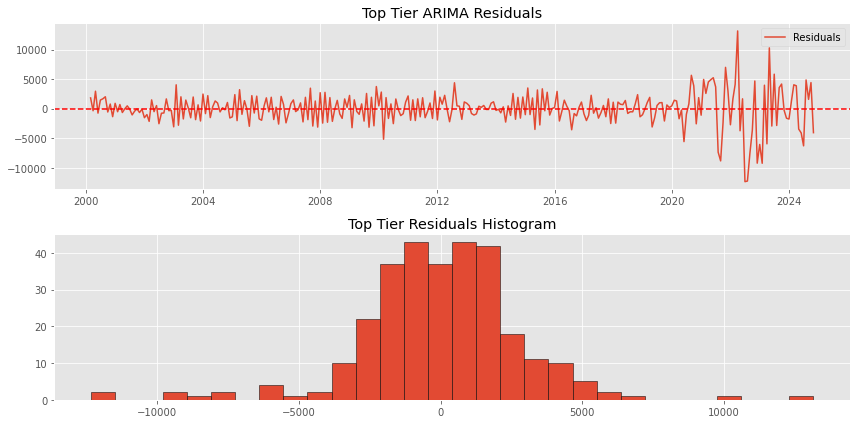

In [ ]:
# Plot residuals for Bottom Tier
bottom_tier_residuals = bottom_tier_model.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bottom_tier_residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Bottom Tier ARIMA Residuals")
plt.legend()

# Histogram of residuals
plt.subplot(2, 1, 2)
plt.hist(bottom_tier_residuals, bins=30, edgecolor='k')
plt.title("Bottom Tier Residuals Histogram")
plt.tight_layout()
plt.show()

# Plot residuals for Top Tier
top_tier_residuals = top_tier_model.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(top_tier_residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Top Tier ARIMA Residuals")
plt.legend()

# Histogram of residuals
plt.subplot(2, 1, 2)
plt.hist(top_tier_residuals, bins=30, edgecolor='k')
plt.title("Top Tier Residuals Histogram")
plt.tight_layout()
plt.show()

# TODO Plot residuals for the rest of the categories

In [73]:
# Define the original time series data
bottom_tier = boulder_bottom_tier["Price"]  # Replace with your actual Bottom Tier time series
top_tier = boulder_top_tier["Price"]       # Replace with your actual Top Tier time series


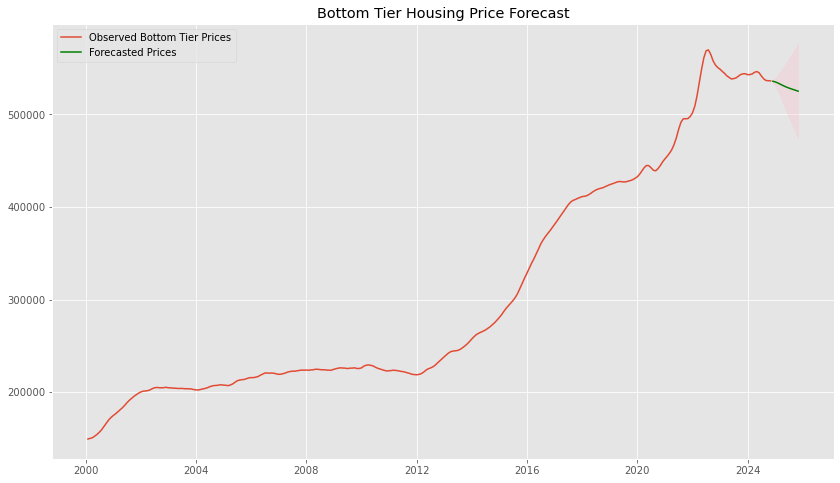

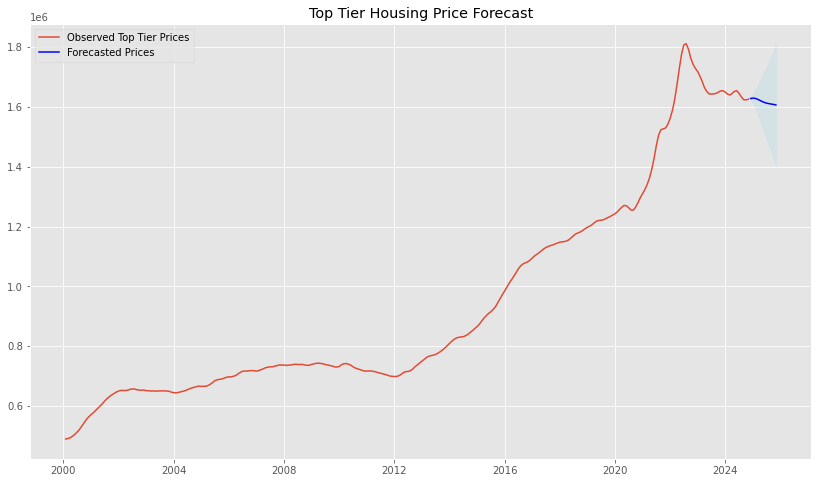

In [ ]:
# Reintegrate Bottom Tier Forecast
forecast_bottom = bottom_tier_model.get_forecast(steps=12)
forecast_bottom_diff = forecast_bottom.predicted_mean
forecast_bottom_index = pd.date_range(start=bottom_tier.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")

# Convert differenced forecast to original scale
forecast_bottom_reintegrated = forecast_bottom_diff.cumsum() + bottom_tier.iloc[-1]

# Reintegrate confidence intervals
forecast_bottom_ci = forecast_bottom.conf_int()
forecast_bottom_ci_reintegrated = forecast_bottom_ci.cumsum() + bottom_tier.iloc[-1]

# Reintegrate Top Tier Forecast
forecast_top = top_tier_model.get_forecast(steps=12)
forecast_top_diff = forecast_top.predicted_mean
forecast_top_index = pd.date_range(start=top_tier.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")

# Convert differenced forecast to original scale
forecast_top_reintegrated = forecast_top_diff.cumsum() + top_tier.iloc[-1]

# Reintegrate confidence intervals
forecast_top_ci = forecast_top.conf_int()
forecast_top_ci_reintegrated = forecast_top_ci.cumsum() + top_tier.iloc[-1]

# Plot Forecasts for Bottom Tier
plt.figure(figsize=(14, 8))
plt.plot(bottom_tier, label="Observed Bottom Tier Prices")
plt.plot(forecast_bottom_index, forecast_bottom_reintegrated, label="Forecasted Prices", color="green")
plt.fill_between(forecast_bottom_index,
                 forecast_bottom_ci_reintegrated.iloc[:, 0],
                 forecast_bottom_ci_reintegrated.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("Bottom Tier Housing Price Forecast")
plt.legend()
plt.show()

# Plot Forecasts for Top Tier
plt.figure(figsize=(14, 8))
plt.plot(top_tier, label="Observed Top Tier Prices")
plt.plot(forecast_top_index, forecast_top_reintegrated, label="Forecasted Prices", color="blue")
plt.fill_between(forecast_top_index,
                 forecast_top_ci_reintegrated.iloc[:, 0],
                 forecast_top_ci_reintegrated.iloc[:, 1],
                 color="lightblue", alpha=0.3)
plt.title("Top Tier Housing Price Forecast")
plt.legend()
plt.show()

# TODO Plot forecasts for the rest of the categories

# Maybe Predict 5 to 20 years into the future with existing data? For Fun to test


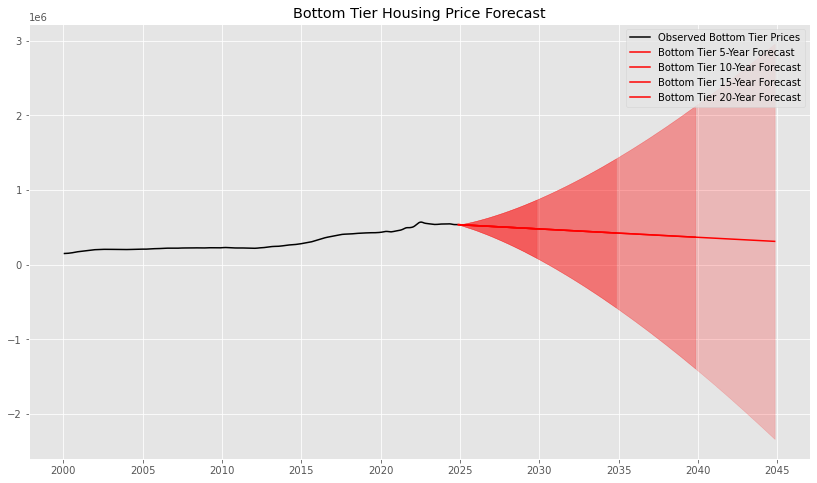

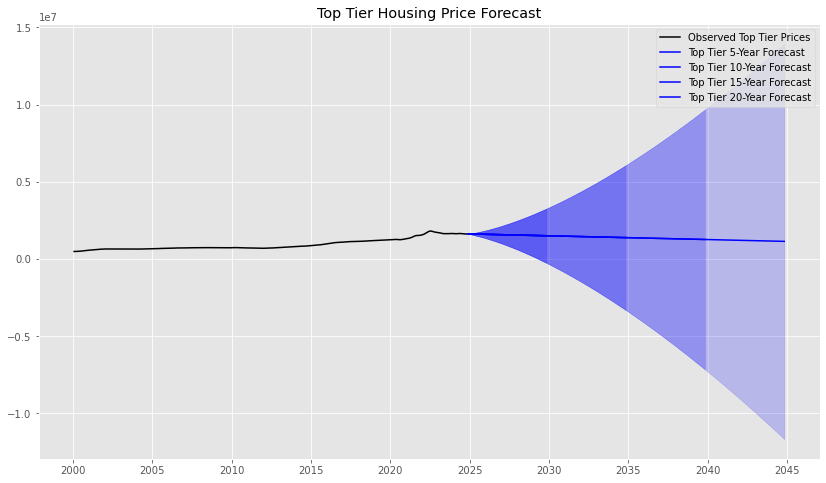

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define forecasting horizons (5, 10, 15, 20 years)
forecast_years = [5, 10, 15, 20]
steps_per_year = 12  # Monthly data, so 12 steps per year

# Function to forecast and re-integrate
def forecast_future(model, original_data, years, color, label):
    steps = years * steps_per_year  # Total forecast steps
    forecast = model.get_forecast(steps=steps)
    forecast_diff = forecast.predicted_mean
    
    # Generate future index
    future_index = pd.date_range(start=original_data.index[-1] + pd.offsets.MonthEnd(), periods=steps, freq="M")
    
    # Convert differenced forecast to original scale
    forecast_reintegrated = forecast_diff.cumsum() + original_data.iloc[-1]
    
    # Reintegrate confidence intervals
    forecast_ci = forecast.conf_int()
    forecast_ci_reintegrated = forecast_ci.cumsum() + original_data.iloc[-1]
    
    # Plot forecast
    plt.plot(future_index, forecast_reintegrated, label=f"{label} {years}-Year Forecast", color=color)
    plt.fill_between(future_index,
                     forecast_ci_reintegrated.iloc[:, 0],
                     forecast_ci_reintegrated.iloc[:, 1],
                     color=color, alpha=0.2)

# Plot forecasts for Bottom Tier
plt.figure(figsize=(14, 8))
plt.plot(bottom_tier, label="Observed Bottom Tier Prices", color="black")
for i, years in enumerate(forecast_years):
    forecast_future(bottom_tier_model, bottom_tier, years, color=f"red", label="Bottom Tier")
plt.title("Bottom Tier Housing Price Forecast")
plt.legend()
plt.show()

# Plot forecasts for Top Tier
plt.figure(figsize=(14, 8))
plt.plot(top_tier, label="Observed Top Tier Prices", color="black")
for i, years in enumerate(forecast_years):
    forecast_future(top_tier_model, top_tier, years, color=f"blue", label="Top Tier")
plt.title("Top Tier Housing Price Forecast")
plt.legend()
plt.show()

# TODO Plot forecasts for the rest of the categories

# SARIMA Patterns: 


/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80296D+01    |proj g|=  8.71930D+00

At iterate    5    f=  1.01423D+01    |proj g|=  1.83129D-01

At iterate   10    f=  1.01188D+01    |proj g|=  4.53699D-01

At iterate   15    f=  1.00553D+01    |proj g|=  1.75670D-01

At iterate   20    f=  1.00498D+01    |proj g|=  2.00713D-02

At iterate   25    f=  1.00377D+01    |proj g|=  3.87409D-01

At iterate   30    f=  1.00251D+01    |proj g|=  7.18535D-03

At iterate   35    f=  1.00247D+01    |proj g|=  5.36119D-02

At iterate   40    f=  9.99666D+00    |proj g|=  2.95779D-01

At iterate   45    f=  9.82912D+00    |proj g|=  1.22705D-01


/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.94586D+00    |proj g|=  3.78449D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   3.784D-01   8.946D+00
  F =   8.9458576862349446     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04568D+01    |proj g|=  6.78830D+01

At iterate    5    f=  1.22972D+01    |proj g|=  1.00535D+00

At iterate   10    f=  1.21957D+01    |proj g|=  1.92530D-01

At iterate   15    f=  1.20921D+01    |proj g|=  1.80664D+00

At iterate   20    f=  1.18522D+01    |proj g|=  2.22323D-01

At iterate   25    f=  1.17585D+01    |proj g|=  5.59380D-01

At iterate   30    f=  1.17286D+01    |proj g|=  9.17718D-02

At iterate   35    f=  1.17123D+01    |proj g|=  1.46576D-01

At iterate   40    f=  1.17077D+01    |proj g|=  6.52557D-02

At iterate   45    f=  1.17040D+01    |proj g|=  7.83880D-02

At iterate   50    f=  1.13620D+01    |proj g|=  1.89246D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/john/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bottom Tier SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  298
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2665.866
Date:                            Sat, 07 Dec 2024   AIC                           5343.731
Time:                                    23:04:00   BIC                           5365.646
Sample:                                01-31-2000   HQIC                          5352.516
                                     - 10-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3989        nan        nan        nan         nan         nan
a

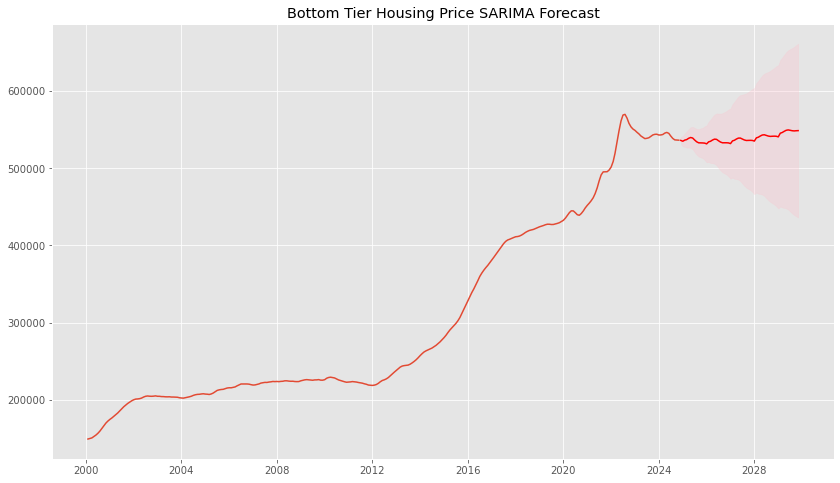

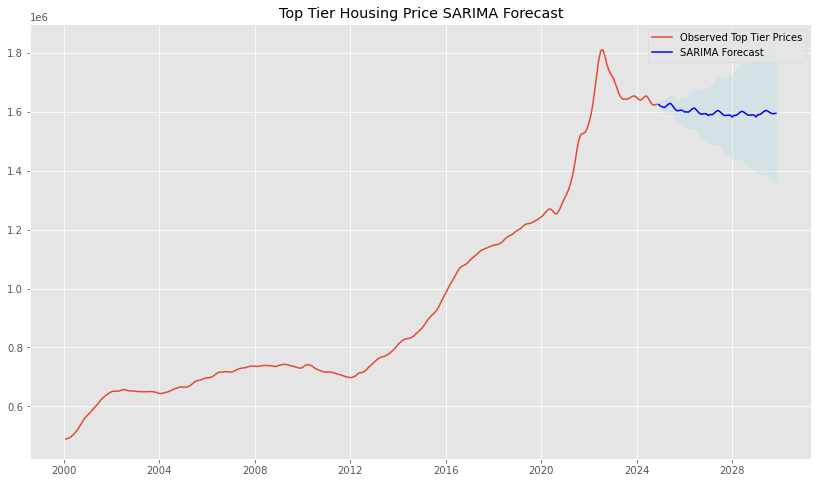

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: Fit a SARIMA model for Bottom Tier
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) - seasonal order
sarima_bottom = SARIMAX(bottom_tier, order=(2, 1, 1), seasonal_order=seasonal_order).fit()
sarima_top = SARIMAX(top_tier, order=(2, 1, 1), seasonal_order=seasonal_order).fit()

# Print SARIMA summary
print("Bottom Tier SARIMA Model Summary:")
print(sarima_bottom.summary())
print("Top Tier SARIMA Model Summary:")
print(sarima_top.summary())




# Forecast with SARIMA for bottm tier
forecast_sarima = sarima_bottom.get_forecast(steps=60)  # 5 years ahead
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_ci = forecast_sarima.conf_int()
# Forecast with SARIMA for Top Tier (e.g., 5 years ahead = 60 months)
forecast_sarima_top = sarima_top.get_forecast(steps=60)
forecast_sarima_top_mean = forecast_sarima_top.predicted_mean
forecast_sarima_top_ci = forecast_sarima_top.conf_int()



# Plot SARIMA forecast
plt.figure(figsize=(14, 8))
plt.plot(bottom_tier, label="Observed Bottom Tier Prices")
plt.plot(forecast_sarima_mean.index, forecast_sarima_mean, label="SARIMA Forecast", color="red")
plt.fill_between(forecast_sarima_mean.index,
                 forecast_sarima_ci.iloc[:, 0],
                 forecast_sarima_ci.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("Bottom Tier Housing Price SARIMA Forecast")

# Plot SARIMA forecast for Top Tier
plt.figure(figsize=(14, 8))
plt.plot(top_tier, label="Observed Top Tier Prices")
plt.plot(forecast_sarima_top_mean.index, forecast_sarima_top_mean, label="SARIMA Forecast", color="blue")
plt.fill_between(forecast_sarima_top_mean.index,
                 forecast_sarima_top_ci.iloc[:, 0],
                 forecast_sarima_top_ci.iloc[:, 1],
                 color="lightblue", alpha=0.3)
plt.title("Top Tier Housing Price SARIMA Forecast")


plt.legend()
plt.show()

# TODO Forecast with SARIMA for the rest of the categories